#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input,MaxPool2D
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [68]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [69]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [70]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [71]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [72]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [8]:
#local에다가 만들기 
exp_id = mlflow.create_experiment("exp4")
exp_id

'3'

## 2 데이터 살펴보기

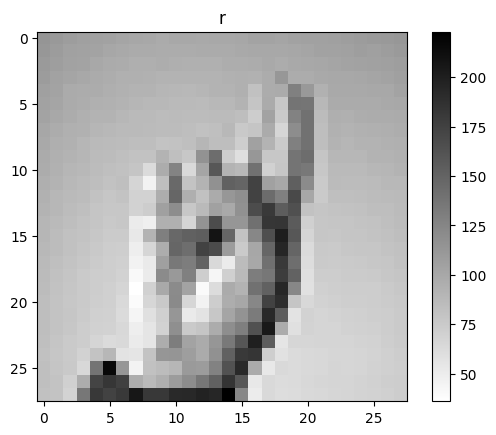

In [9]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [73]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1000, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state = 20)

In [75]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [76]:
# 모두 넘파이로 변환
x_train, x_val, y_train, y_val = x_train.values, x_val.values, y_train.values, y_val.values

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [77]:
x_train = x_train.reshape(5000,28,28,1)
x_val = x_val.reshape(2000,28,28,1)

In [78]:
x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [79]:
x_train = x_train / 255.
x_val = x_val / 255.

## 4.모델링

### (1) 모델1

In [37]:
with mlflow.start_run(experiment_id=exp_id):
    
    mlflow.keras.autolog()
    clear_session()

    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

    history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history
    
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="sign_language")
    
    mlflow.keras.autolog(disable = True)


Epoch 1/10
125/125 [==============================] - 6s 37ms/step - loss: 2.9681 - val_loss: 2.5826
Epoch 2/10
125/125 [==============================] - 4s 33ms/step - loss: 1.9652 - val_loss: 1.5464
Epoch 3/10
125/125 [==============================] - 4s 32ms/step - loss: 1.2723 - val_loss: 1.0995
Epoch 4/10
125/125 [==============================] - 4s 31ms/step - loss: 0.8961 - val_loss: 0.8232
Epoch 5/10
125/125 [==============================] - 4s 32ms/step - loss: 0.6944 - val_loss: 0.6982
Epoch 6/10
125/125 [==============================] - 4s 29ms/step - loss: 0.5338 - val_loss: 0.5471
Epoch 7/10
125/125 [==============================] - 4s 32ms/step - loss: 0.4306 - val_loss: 0.4212
Epoch 8/10
125/125 [==============================] - 4s 28ms/step - loss: 0.3488 - val_loss: 0.3844
Epoch 9/10
125/125 [==============================] - 4s 32ms/step - loss: 0.2947 - val_loss: 0.3239
Epoch 10/10
1/1 [==============================] - 0s 135ms/step


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp8zknen0_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp8zknen0_\model\data\model\assets
2023/05/18 15:23:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\User\anaconda3\envs\ml_pipeline\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/05/18 15:23:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptw3n9mw8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptw3n9mw8\model\data\model\assets
Successfully registered model 'sign_language'.
2023/05/18 15:23:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sign_language, version 1
Created version '1' of model 'sign_language'.


* 학습곡선

In [40]:
# model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

# history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history

* 예측 및 검증

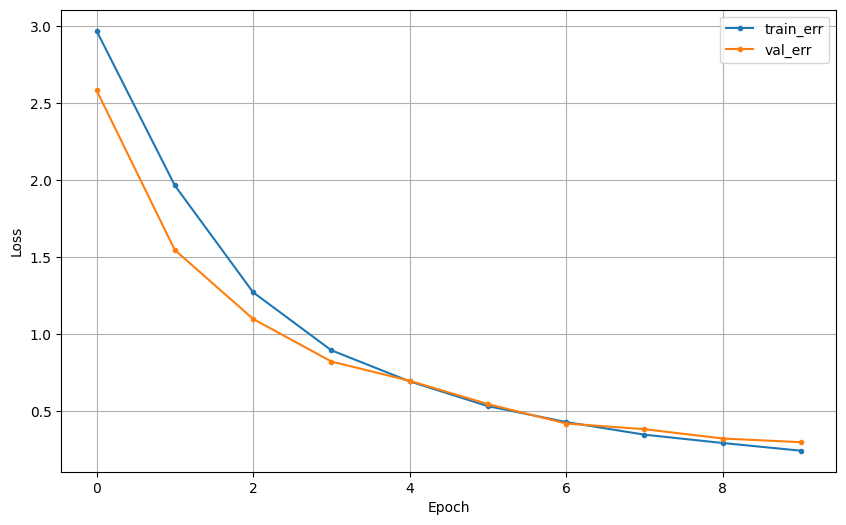

In [38]:
dl_history_plot(history)

In [39]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)
print(accuracy_score(y_val,pred_1))

63/63 [==============================] - 0s 4ms/step
0.9195


### (2) 모델2

In [42]:
with mlflow.start_run(experiment_id=exp_id, run_name='a031341'):
    mlflow.keras.autolog()
    
    clear_session()

    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Conv2D(32, kernel_size=3, padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history
    #Sign_Signal_24 -> 개인ㅌ이 다 필요
    #run_name
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="Sign_Signal_24")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/10
125/125 [==============================] - 7s 44ms/step - loss: 2.9375 - val_loss: 2.1675
Epoch 2/10
125/125 [==============================] - 5s 37ms/step - loss: 1.3578 - val_loss: 0.8352
Epoch 3/10
125/125 [==============================] - 5s 39ms/step - loss: 0.6824 - val_loss: 0.5693
Epoch 4/10
125/125 [==============================] - 5s 37ms/step - loss: 0.4432 - val_loss: 0.4233
Epoch 5/10
125/125 [==============================] - 4s 34ms/step - loss: 0.3231 - val_loss: 0.3128
Epoch 6/10
125/125 [==============================] - 5s 38ms/step - loss: 0.2171 - val_loss: 0.2038
Epoch 7/10
125/125 [==============================] - 4s 35ms/step - loss: 0.1659 - val_loss: 0.2187
Epoch 8/10
125/125 [==============================] - 4s 36ms/step - loss: 0.1246 - val_loss: 0.1728
Epoch 9/10
125/125 [==============================] - 5s 41ms/step - loss: 0.0949 - val_loss: 0.1442
Epoch 10/10
1/1 [==============================] - 0s 176ms/step


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpazzuciep\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpazzuciep\model\data\model\assets
2023/05/18 15:25:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp3xewejir\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp3xewejir\model\data\model\assets
Registered model 'sign_language' already exists. Creating a new version of this model...
2023/05/18 15:25:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sign_language, version 2
Created version '2' of model 'sign_language'.


In [43]:
# history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history

* 학습곡선

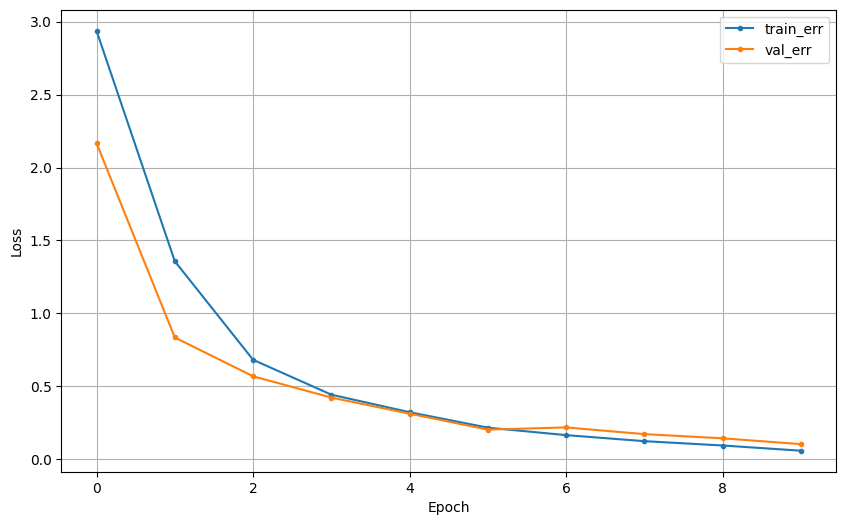

In [44]:
dl_history_plot(history)

* 예측 및 검증

In [45]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)
print(accuracy_score(y_val,pred_1))

63/63 [==============================] - 0s 7ms/step
0.973


## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [80]:
model_uri = "models:/sign_language/production" 
model3 = mlflow.keras.load_model(model_uri)

RestException: RESOURCE_DOES_NOT_EXIST: Registered Model with name=sign_language not found

In [62]:
x_test = x_test.values
x_test = x_test.reshape(1000, 28, 28, 1)
x_test = x_test / 255.
y_pred = model3.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))


32/32 [==============================] - 0s 7ms/step


In [63]:
y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

0.968


### 제출

In [81]:
mlflow_uri ="http://mini7-mlflow.carpediem.so/"
mlflow.set_tracking_uri(mlflow_uri)

In [65]:
exp_id = mlflow.create_experiment('experiment_24')
exp_id
#실험 아이디:55

'55'

In [82]:
with mlflow.start_run(experiment_id='55', run_name='a031341'):
    mlflow.keras.autolog()
    
    clear_session()

    model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Conv2D(32, kernel_size=3, padding='same', strides =1, activation='relu'),
                        MaxPooling2D(pool_size=2, strides=2),
                        Flatten(),
                        Dense(128, activation = 'relu'),
                        Dense(26, activation='softmax')
    ])
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history
    #Sign_Signal_24 -> 개인ㅌ이 다 필요
    #run_name
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="Sign_Signal_24")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/10
125/125 [==============================] - 9s 50ms/step - loss: 2.7735 - val_loss: 1.7698
Epoch 2/10
125/125 [==============================] - 6s 48ms/step - loss: 1.1603 - val_loss: 0.7684
Epoch 3/10
125/125 [==============================] - 6s 44ms/step - loss: 0.6355 - val_loss: 0.5848
Epoch 4/10
125/125 [==============================] - 6s 48ms/step - loss: 0.4343 - val_loss: 0.3678
Epoch 5/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2781 - val_loss: 0.2653
Epoch 6/10
125/125 [==============================] - 6s 49ms/step - loss: 0.2116 - val_loss: 0.2310
Epoch 7/10
125/125 [==============================] - 6s 48ms/step - loss: 0.1372 - val_loss: 0.1611
Epoch 8/10
125/125 [==============================] - 6s 45ms/step - loss: 0.0956 - val_loss: 0.1356
Epoch 9/10
125/125 [==============================] - 6s 49ms/step - loss: 0.0735 - val_loss: 0.0919
Epoch 10/10
1/1 [==============================] - 0s 301ms/step


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdwnyfcaq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdwnyfcaq\model\data\model\assets
2023/05/18 16:42:11 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpvtd_bmn6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpvtd_bmn6\model\data\model\assets
Registered model 'Sign_Signal_24' already exists. Creating a new version of this model...
2023/05/18 16:42:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal_24, version 3
Created version '3' of model 'Sign_Signal_24'.


In [91]:
model_uri = "models:/Sign_Signal_24/6" 
model6 = mlflow.keras.load_model(model_uri)

x_test = x_test.values
x_test = x_test.reshape(1000, 28, 28, 1)
x_test = x_test / 255.
y_pred = model6.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 11ms/step
0.889


In [92]:
model_uri = "models:/Sign_Signal_24/5" 
model5 = mlflow.keras.load_model(model_uri)

y_pred = model5.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 2s 47ms/step
0.999


In [93]:
model_uri = "models:/Sign_Signal_24/4" 
model4 = mlflow.keras.load_model(model_uri)

y_pred = model4.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 6ms/step
0.039


In [94]:
model_uri = "models:/Sign_Signal_24/3" 
model3 = mlflow.keras.load_model(model_uri)

y_pred = model3.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 9ms/step
0.974


In [95]:
model_uri = "models:/Sign_Signal_24/2" 
model2 = mlflow.keras.load_model(model_uri)

y_pred = model2.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 5ms/step
0.999


In [96]:
model_uri = "models:/Sign_Signal_24/1" 
model1 = mlflow.keras.load_model(model_uri)

y_pred = model1.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 9ms/step
0.97


In [97]:
model_uri = "models:/Sign_Signal_24/latest" 
model11 = mlflow.keras.load_model(model_uri)

y_pred = model11.predict(x_test)

y_pred = y_pred.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 5ms/step
0.988
